In [1]:
import h5py
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl 
from matplotlib import pyplot as plt
import glob
from uncertainties import ufloat
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit
from scipy import integrate
import simweights


In [2]:
def add_simweights(df: pd.DataFrame, model_class: list[simweights._fluxes.CosmicRayFlux] | simweights._fluxes.CosmicRayFlux):
    """ Adds weights for all primary models in model_class (from simweights._fluxes) to the df.
        The key will be "simweights_{name of model_class}" for each model. 
    """
    
    if not isinstance(model_class, list):
        model_class = [model_class]
    

    for primary_model in model_class:   
        df['simweights_'+primary_model.__name__] = np.empty(len(df))

    weight_keys = [
        "CylinderLength",
        "CylinderRadius",
        "EnergyPrimaryMax",
        "EnergyPrimaryMin",
        "NEvents",
        "OverSampling",
        "ParticleType",
        "PrimaryEnergy",
        "PrimarySpectralIndex",
        "PrimaryType",
        "ThetaMax",
        "ThetaMin",
        "Weight",
    ]

    # loop through different files
    e_low = np.unique(df.EnergyPrimaryMin)

    for e_l in e_low:
        mask = df.EnergyPrimaryMin == e_l
        print(f'minimum primary energy: {e_l} GeV')
        number_corsika_files = len(np.unique(df.Run[mask]))
        print('number of processed files: ', number_corsika_files)

        CorsikaWeightMap: dict = {k: [df[k][mask]] for k in weight_keys}
        PolyplopiaPrimary: dict = {k: [df[k][mask]] for k in ["type", "energy", "zenith"]}


        fobj = {"CorsikaWeightMap": CorsikaWeightMap, "PolyplopiaPrimary": PolyplopiaPrimary}
        wobj = simweights.CorsikaWeighter(fobj, nfiles=number_corsika_files)

        for primary_model in model_class:   
            df.loc[mask, 'simweights_'+primary_model.__name__] = wobj.get_weights(primary_model())

In [3]:
CorsikaWeightMap=pd.DataFrame([])
for files in glob.glob('/net/big-tank/POOL/users/pgutjahr/data/data/leading_muons/evaluation_01/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    df_poly=pd.read_hdf(files,key='PolyplopiaPrimary')
    df_poly=pd.concat([df_poly,pd.read_hdf(files,key='CorsikaWeightMap')],axis=1)
    CorsikaWeightMap=pd.concat([CorsikaWeightMap,df_poly])

In [4]:
add_simweights(CorsikaWeightMap,[simweights.GaisserH3a, simweights.GlobalFitGST, simweights.GlobalSplineFit5Comp])

minimum primary energy: 600.0 GeV
number of processed files:  20
minimum primary energy: 1000000.0 GeV
number of processed files:  20
minimum primary energy: 100000000.0 GeV
number of processed files:  100
minimum primary energy: 1000000000.0 GeV
number of processed files:  18


In [5]:
CorsikaWeightMap

,Run,Event,SubEvent,SubEventStream,exists,x,y,z,time,zenith,...,PrimaryEnergy,PrimarySpectralIndex,PrimaryType,ThetaMax,ThetaMin,TimeScale,Weight,simweights_GaisserH3a,simweights_GlobalFitGST,simweights_GlobalSplineFit5Comp
0,300120430,0,0,0,1,447398.232980,152719.563129,95188.068089,-1.593502e+06,1.373054,...,7.293339e+08,-1.0,2.212000e+03,1.570622,0.0,26546.429981,1.0,2.358374e-09,1.595931e-08,1.035837e-08
1,300120430,1,0,0,1,33899.447757,-482181.651191,94604.463690,-1.631969e+06,1.377487,...,8.888007e+08,-1.0,2.212000e+03,1.570622,0.0,26546.429981,1.0,1.651033e-09,1.070315e-08,7.317688e-09
2,300120430,2,0,0,1,77871.207398,-23607.586326,111419.755204,-4.485066e+05,0.631284,...,1.340705e+08,-1.0,2.212000e+03,1.570622,0.0,26546.429981,1.0,3.892131e-08,2.702129e-07,1.875778e-07
3,300120430,3,0,0,1,-270014.013121,97688.714620,105749.155286,-1.009520e+06,1.218835,...,4.332213e+08,-1.0,2.212000e+03,1.570622,0.0,26546.429981,1.0,5.670474e-09,4.155665e-08,2.586633e-08
4,300120430,4,0,0,1,3450.323577,-258220.200120,106975.474490,-9.212771e+05,1.177270,...,2.611335e+08,-1.0,2.212000e+03,1.570622,0.0,26546.429981,1.0,1.258158e-08,9.636437e-08,6.156470e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,300100010,5109,0,0,1,-163119.486521,17736.554459,109890.633720,-6.483994e+05,0.982899,...,7.044994e+05,-1.0,1.000261e+09,1.570622,0.0,0.000340,1.0,5.921142e-03,1.177786e-02,3.697041e-03
314,300100010,5110,0,0,1,-136656.243259,-154919.514994,108709.289949,-7.681074e+05,1.088272,...,5.732238e+05,-1.0,1.000261e+09,1.570622,0.0,0.000340,1.0,8.245111e-03,1.591091e-02,5.494485e-03
315,300100010,5121,0,0,1,31623.079673,-28370.322099,111778.312726,-3.874673e+05,0.364527,...,9.996433e+05,-1.0,1.000261e+09,1.570622,0.0,0.000340,1.0,3.376132e-03,6.942518e-03,1.880501e-03
316,300100010,5150,0,0,1,-17235.451389,139408.256976,110437.807863,-5.858467e+05,0.905704,...,2.057524e+05,-1.0,1.000261e+09,1.570622,0.0,0.000340,1.0,4.277329e-02,6.585162e-02,3.718669e-02


In [6]:
path = '/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/30010/level2/00000-00999/Corsika_30010_level2_00000000.hdf5'
data = h5py.File(path, 'r')
data.keys()

<KeysViewHDF5 ['CorsikaWeightMap', 'DeepLearningReco_PromtMu_L2_direction', 'DeepLearningReco_PromtMu_L2_direction_I3Particle', 'DeepLearningReco_direction_big', 'DeepLearningReco_direction_big_I3Particle', 'DeepLearningReco_direction_bigger_conv', 'DeepLearningReco_direction_bigger_conv_2', 'DeepLearningReco_direction_bigger_conv_2_I3Particle', 'DeepLearningReco_direction_bigger_conv_I3Particle', 'DeepLearningReco_direction_even_bigger', 'DeepLearningReco_direction_even_bigger_I3Particle', 'DeepLearningReco_direction_smaller_conv', 'DeepLearningReco_direction_smaller_conv_I3Particle', 'DeepLearningReco_direction_smaller_conv_pooling', 'DeepLearningReco_direction_smaller_conv_pooling_I3Particle', 'DeepLearningReco_energy_bigger_convolutional', 'DeepLearningReco_energy_bigger_convolutional_I3Particle', 'DeepLearningReco_energy_bigger_convolutional_max', 'DeepLearningReco_energy_bigger_convolutional_max_I3Particle', 'DeepLearningReco_energy_bigger_convolutional_max_biasV2', 'DeepLearning

In [7]:
# reading a file to check the contents of a key

freek= pd.read_hdf(path, key='DeepLearningReco_PromtMu_L2_direction')
freek.keys()

Index(['Run', 'Event', 'SubEvent', 'SubEventStream', 'exists',
       'PrimaryAzimuth', 'PrimaryAzimuth_uncertainty', 'PrimaryZenith',
       'PrimaryZenith_uncertainty', 'direction_x', 'direction_x_uncertainty',
       'direction_y', 'direction_y_uncertainty', 'direction_z',
       'direction_z_uncertainty', 'runtime_prediction', 'runtime_preprocess',
       'runtime_write'],
      dtype='object')

In [8]:
files =  glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5')

In [9]:
# Monte Carlo
MCall_dfs = []

for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    #print(f'Loading{files}')
    MCnew_df = pd.read_hdf(files, key='MCLabelsLeadingMuons')
    MCall_dfs.append(MCnew_df)

MCdf = pd.concat(MCall_dfs)

# First DNN with 8 layers
DNNall_dfs = []


for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    #print(f'Loading{files}')
    DNNnew_df = pd.read_hdf(files, key='DeepLearningReco_direction_smaller_conv')
    DNNall_dfs.append(DNNnew_df)

DNNdf = pd.concat(DNNall_dfs)

# prompt info 
prompt_dfs = []

for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    prompt_new_df = pd.read_hdf(files, key='MCLabelsMostEnergeticMuonParentInfo')
    prompt_dfs.append(prompt_new_df)

prompt_info_df = pd.concat(prompt_dfs) 

# second Dnn with 4 layers
DNN_one_all_dfs = []

for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    #print(f'Loading{files}')
    DNN_one_new_df = pd.read_hdf(files, key='DeepLearningReco_PromtMu_L2_direction')
    DNN_one_all_dfs.append(DNN_one_new_df)

DNN_one_df = pd.concat(DNN_one_all_dfs)

#Wall_dfs = []

#
#for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV2/dnn_manyV2/Corsika/3001*/level2/00000-00999/*'):
#    #print(f'Loading{files}')
#    Wnew_df = pd.read_hdf(files, key='weights')
#    Wall_dfs.append(Wnew_df)
#
#Weights_df = pd.concat(Wall_dfs)



#Lall_dfs = []
#
#for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV2/dnn_manyV2/Corsika/3001*/level2/00000-00999/*'):
#    #print(f'Loading{files}')
#    Lnew_df= pd.read_hdf(files, key='MCLabelsLeadingMuons')
#    Lall_dfs.append(Lnew_df)
#
#leading_df = pd.concat(Lall_dfs)



/scratch/bbrandt/muonspace/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'p_is_leading_muon_fr0.50_entry'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/scratch/bbrandt/muonspace/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'p_is_leading_muon_fr0.50_mctree'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/scratch/bbrandt/muonspace/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'p_is_leading_muon_fr0.90_entry'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not 

In [10]:
prompt_info_df.is_prompt_dennis

0     0.0
1     0.0
2     0.0
3     1.0
4     0.0
     ... 
71    0.0
72    0.0
73    0.0
74    0.0
75    0.0
Name: is_prompt_dennis, Length: 19644, dtype: float64

In [11]:
MPEall_dfs = []

for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    #print(f'Loading{files}')
    MPEnew_df = pd.read_hdf(files, key='MPEFit')
    MPEall_dfs.append(MPEnew_df)

MPEdf = pd.concat(MPEall_dfs)

In [12]:
# pooling DNN
DNNpall_dfs = []


for files in glob.glob('/net/big-tank/POOL/projects/icecube/prompt_muons/evaluated_dnn_manyV4/dnn_manyV4/Corsika/3001*/level2/00000-00999/*0.hdf5'):
    #print(f'Loading{files}')
    DNNpnew_df = pd.read_hdf(files, key='DeepLearningReco_direction_smaller_conv_pooling')
    DNNpall_dfs.append(DNNpnew_df)

DNNpdf = pd.concat(DNNpall_dfs)

In [13]:
DNN_Primary_Zenith_deg=DNNdf.PrimaryZenith*360/(2*np.pi)
DNN_Primary_Azimuth_deg=DNNdf.PrimaryAzimuth*360/(2*np.pi)
DNN_one_Primary_Zenith_deg=DNN_one_df.PrimaryZenith*360/(2*np.pi)
DNN_one_Primary_Azimuth_deg=DNN_one_df.PrimaryAzimuth*360/(2*np.pi)
MC_Primary_Zenith_deg=MCdf.PrimaryZenith*360/(2*np.pi)
MC_Primary_Azimuth_deg=MCdf.PrimaryAzimuth*360/(2*np.pi)


In [14]:
np.size(DNNdf.PrimaryZenith)

19644

In [15]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#   network with 4 layers

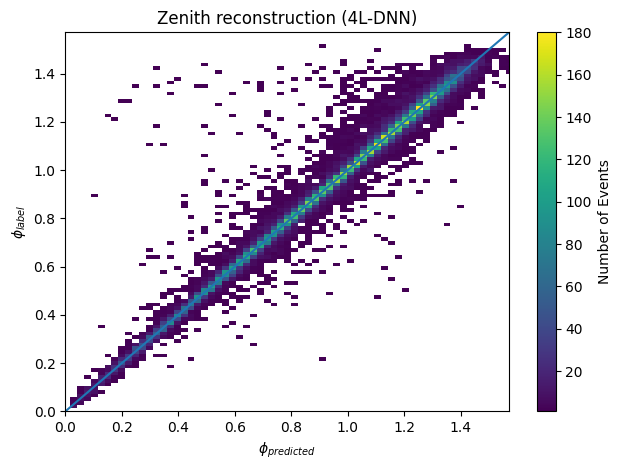

In [16]:
# Zenith reconstruction in radians

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(DNNdf.PrimaryZenith, MCdf.PrimaryZenith, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,np.pi/2)
plt.ylim(0,np.pi/2)
plt.xlabel(r'$\phi_{predicted}$')
plt.ylabel(r'$\phi_{label}$')
plt.title('Zenith reconstruction (4L-DNN)')
plt.tight_layout()
##plt.savefig('zenith_4L')
#plt.show()

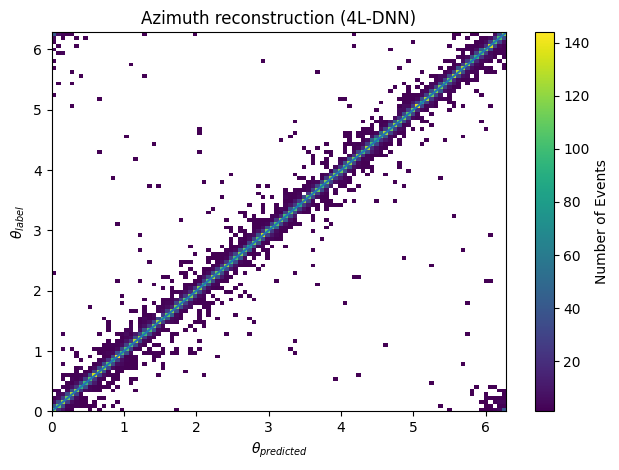

In [17]:
# Azimuth reconstruction in radians

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(DNNdf.PrimaryAzimuth, MCdf.PrimaryAzimuth, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
plt.xlabel(r'$\theta_{predicted}$')
plt.ylabel(r'$\theta_{label}$')
plt.title('Azimuth reconstruction (4L-DNN)')
plt.tight_layout()
##plt.savefig('azimuth_4L')
plt.show()

In [18]:
DNNdf.PrimaryZenith.values

array([0.86967206, 1.18865705, 0.89422321, ..., 1.32178712, 0.63318348,
       1.19048858])

In [19]:
#   Uncertainty cut for Zenith uncertainty
uncertainty_normed_zenith=(DNNdf.PrimaryZenith_uncertainty-np.min(DNNdf.PrimaryZenith_uncertainty))/(np.max(DNNdf.PrimaryZenith_uncertainty)-np.min(DNNdf.PrimaryZenith_uncertainty))
uncertainty_normed_azimuth=(DNNdf.PrimaryAzimuth_uncertainty-np.min(DNNdf.PrimaryAzimuth_uncertainty))/(np.max(DNNdf.PrimaryAzimuth_uncertainty)-np.min(DNNdf.PrimaryAzimuth_uncertainty))

#   Zenith

prediction_cut_zenith=DNNdf.PrimaryZenith[uncertainty_normed_zenith <= np.quantile(uncertainty_normed_zenith, 0.8)]
label_cut_zenith=MCdf.PrimaryZenith[uncertainty_normed_zenith <= np.quantile(uncertainty_normed_zenith, 0.8)]
#   Azimuth
prediction_cut_azimuth=DNNdf.PrimaryAzimuth[uncertainty_normed_zenith <= np.quantile(uncertainty_normed_zenith, 0.8)]
label_cut_azimuth=MCdf.PrimaryAzimuth[uncertainty_normed_zenith <= np.quantile(uncertainty_normed_zenith, 0.8)]

plot_energy=MCdf.bundle_energy_at_entry[uncertainty_normed_zenith <= np.quantile(uncertainty_normed_zenith, 0.8)]


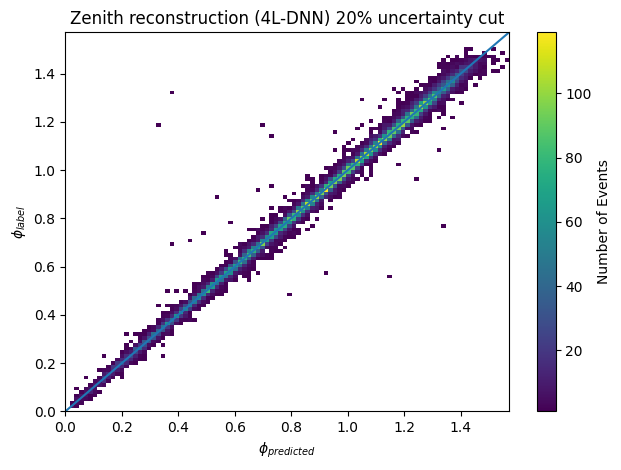

In [20]:
# Zenith reconstruction in radians and uncertainty cut of 20%

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(prediction_cut_zenith, label_cut_zenith, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,np.pi/2)
plt.ylim(0,np.pi/2)
plt.xlabel(r'$\phi_{predicted}$')
plt.ylabel(r'$\phi_{label}$')
plt.title('Zenith reconstruction (4L-DNN) 20% uncertainty cut')
plt.tight_layout()
##plt.savefig('zenith_4L_cut')

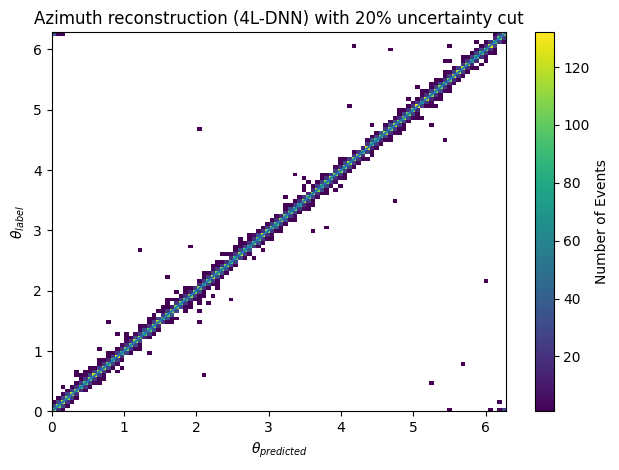

In [21]:
# Azimuth reconstruction in radians and uncertainty cut of 20%

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(prediction_cut_azimuth, label_cut_azimuth, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
plt.xlabel(r'$\theta_{predicted}$')
plt.ylabel(r'$\theta_{label}$')
plt.title('Azimuth reconstruction (4L-DNN) with 20% uncertainty cut')
plt.tight_layout()
#plt.savefig('azimuth_4L_cut')

In [22]:
# opening angle for DNN vs. MC
phi_p=DNNdf.PrimaryZenith
phi_l=MCdf.PrimaryZenith
theta_p=DNNdf.PrimaryAzimuth 
theta_l=MCdf.PrimaryAzimuth 

# x,y,z coordinates of vektors for prediction
theta_px=np.sin(theta_p)*np.cos(phi_p)
theta_py=np.sin(theta_p)*np.sin(phi_p)
theta_pz=np.cos(theta_p)

# x,y,z coordinates of vektors for label
theta_lx=np.sin(theta_l)*np.cos(phi_l)
theta_ly=np.sin(theta_l)*np.sin(phi_l)
theta_lz=np.cos(theta_l)

# absolut value of vekotr
absolute_p=np.sqrt(theta_px**2+theta_py**2+theta_pz**2)
absolute_l=np.sqrt(theta_lx**2+theta_ly**2+theta_lz**2)

alpha=np.arccos((theta_px*theta_lx+theta_py*theta_ly+theta_pz*theta_lz)/(absolute_p*absolute_l))

alpha_deg=alpha*360/(2*np.pi)

In [23]:
# opening angle for DNN vs. MC with uncertainty cut

phi_p_cut=prediction_cut_zenith.values
phi_l_cut=label_cut_zenith.values
theta_p_cut=prediction_cut_azimuth.values
theta_l_cut=label_cut_azimuth.values

# x,y,z coordinates of vektors for prediction
theta_px_cut=np.sin(theta_p_cut)*np.cos(phi_p_cut)
theta_py_cut=np.sin(theta_p_cut)*np.sin(phi_p_cut)
theta_pz_cut=np.cos(theta_p_cut)

# x,y,z coordinates of vektors for label
theta_lx_cut=np.sin(theta_l_cut)*np.cos(phi_l_cut)
theta_ly_cut=np.sin(theta_l_cut)*np.sin(phi_l_cut)
theta_lz_cut=np.cos(theta_l_cut)

# absolut value of vekotr
absolute_p_cut=np.sqrt(theta_px_cut**2+theta_py_cut**2+theta_pz_cut**2)
absolute_l_cut=np.sqrt(theta_lx_cut**2+theta_ly_cut**2+theta_lz_cut**2)
# opening angle

alpha_cut=np.arccos((theta_px_cut*theta_lx_cut+theta_py_cut*theta_ly_cut+theta_pz_cut*theta_lz_cut)/(absolute_p_cut*absolute_l_cut))

alpha_deg_cut=alpha_cut*360/(2*np.pi)

In [24]:
# opening angle comparission for MPEFIt vs. MC leading muon 
# Zenith = phi ∈[0,pi]
# Azimuth = theta ∈[0,2pi]



mpe_phi_predict=MPEdf.zenith
mpe_phi_label=MCdf.PrimaryZenith
mpe_theta_predict=MPEdf.azimuth 
mpe_theta_label=MCdf.PrimaryAzimuth 

# x,y,z coordinates of vektors for prediction
mpe_theta_predict_x=np.sin(mpe_theta_predict)*np.cos(mpe_phi_predict)
mpe_theta_predict_y=np.sin(mpe_theta_predict)*np.sin(mpe_phi_predict)
mpe_theta_predict_z=np.cos(mpe_theta_predict)

# x,y,z coordinates of vektors for label
mpe_theta_label_x=np.sin(mpe_theta_label)*np.cos(mpe_phi_label)
mpe_theta_label_y=np.sin(mpe_theta_label)*np.sin(mpe_phi_label)
mpe_theta_label_z=np.cos(mpe_theta_label)

# absolut value of vekotr
absolute_mpe_predict=np.sqrt(mpe_theta_predict_x**2+mpe_theta_predict_y**2+mpe_theta_predict_z**2)
absolute_mpe_label=np.sqrt(mpe_theta_label_x**2+mpe_theta_label_y**2+mpe_theta_label_z**2)

MPE_alpha=np.arccos((mpe_theta_predict_x*mpe_theta_label_x+mpe_theta_predict_y*mpe_theta_label_y+mpe_theta_predict_z*mpe_theta_label_z)/(absolute_mpe_predict*absolute_mpe_label))

MPE_alpha_deg=MPE_alpha*360/(2*np.pi)
print(MPE_alpha_deg)
print(np.isfinite(MPE_alpha_deg))

0      1.094590
1     10.368388
2     11.191407
3      0.160284
4      0.707718
        ...    
71    21.545534
72     2.341521
73     0.113526
74     0.624476
75     6.775977
Length: 19644, dtype: float64
0     True
1     True
2     True
3     True
4     True
      ... 
71    True
72    True
73    True
74    True
75    True
Length: 19644, dtype: bool


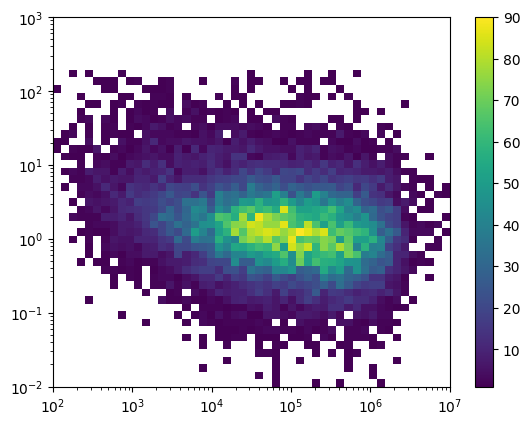

In [25]:
xaxes=np.logspace(2,7)
yaxes=np.logspace(-2,3)


plt.hist2d(MCdf.bundle_energy_at_entry, alpha_deg, bins=[xaxes,yaxes] ,cmin=1)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

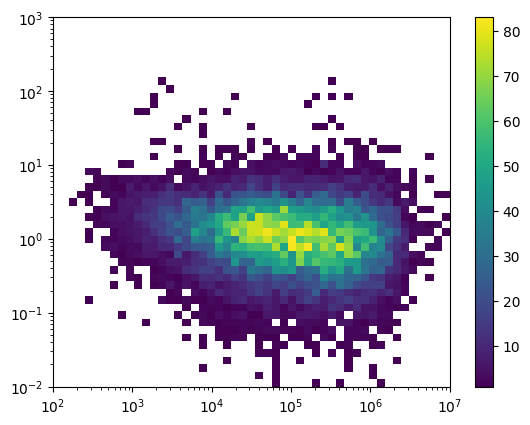

In [26]:
plt.hist2d(plot_energy, alpha_deg_cut, bins=[xaxes,yaxes] ,cmin=1)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [27]:
# Calculate angle medians for energy bins for uncut 

angle_median=np.zeros(np.size(xaxes)-1)
x=np.digitize(MCdf.bundle_energy_at_entry, bins=xaxes)-1
#print(x)
for n in range(np.size(xaxes)-1):
    z=alpha_deg[x==n]
    angle_median[n]=np.median(z)
#print(angle_median)
#print(max(x))

In [28]:
# Calculate angle medians for energy bins for cut 

angle_median_cut=np.zeros(np.size(xaxes)-1)
y=np.digitize(plot_energy, bins=xaxes)-1
#print(y)
for i in range(np.size(xaxes)-1):
    k=alpha_deg_cut[y==i]
    angle_median_cut[i]=np.median(k)
#print(angle_median_cut)
#print(max(y))

/scratch/bbrandt/muonspace/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/bbrandt/muonspace/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
# Calculate angle means for energy bins for uncut 

angle_mean=np.zeros(np.size(xaxes)-1)
x=np.digitize(MCdf.bundle_energy_at_entry, bins=xaxes)-1
#print(x)
for n in range(np.size(xaxes)-1):
    z=alpha_deg[x==n]
    angle_mean[n]=np.mean(z)
#print(angle_mean)
#print(max(x))

In [30]:
# Calculate angle means for energy bins for cut 

angle_mean_cut=np.zeros(np.size(xaxes)-1)
y=np.digitize(plot_energy, bins=xaxes)-1
#print(y)
for i in range(np.size(xaxes)-1):
    k=alpha_deg_cut[y==i]
    angle_mean_cut[i]=np.mean(k)
#print(angle_mean_cut)
#print(max(y))

In [31]:
# Calculate angle medians for energy bins for MPEFit

MPE_angle_median=np.zeros(np.size(xaxes)-1)
#print(np.size(angle_median_leading))
mpe_count=np.digitize(MCdf.entry_energy, bins=xaxes)-1
#print(count)
for i in range(np.size(xaxes)-1):
    pre_median_mpe=MPE_alpha_deg[mpe_count==i]
    MPE_angle_median[i]=np.nanmedian(pre_median_mpe)
#print(MPE_angle_median_leading)

/scratch/bbrandt/muonspace/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [32]:
# Calculate angle means for energy bins for MPEFit 

MPE_angle_mean=np.zeros(np.size(xaxes)-1)
#print(np.size(angle_median_leading))
mpe_count=np.digitize(MCdf.entry_energy, bins=xaxes)-1
#print(count)
for i in range(np.size(xaxes)-1):
    pre_mean_mpe=MPE_alpha_deg[mpe_count==i]
    MPE_angle_mean[i]=np.mean(pre_mean_mpe)
#print(MPE_angle_median_leading)

In [33]:
# get middle value for energy in logarythimc bins

logarythmic_bins=np.log10(xaxes)
#print(logarythmic_bins)
mid_value_bin_log=logarythmic_bins[:-1]+np.diff(logarythmic_bins)/2
#print(mid_value_bin_log)
middle_value_non_log=10**mid_value_bin_log
#print(middle_value_non_log)

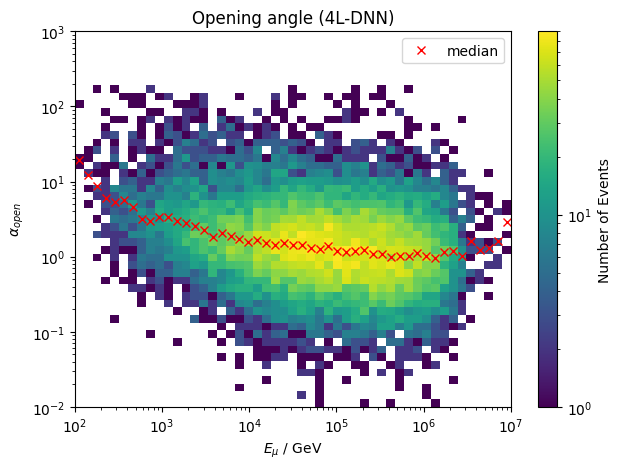

In [34]:
# hist uncut median
plt.hist2d(MCdf.bundle_energy_at_entry, alpha_deg, bins=[xaxes,yaxes] ,cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_median,'xr', label='median')
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{open}$')
plt.colorbar(label='Number of Events')
plt.title('Opening angle (4L-DNN)')
plt.legend()
plt.tight_layout()
#plt.savefig('alpha_4L_median')

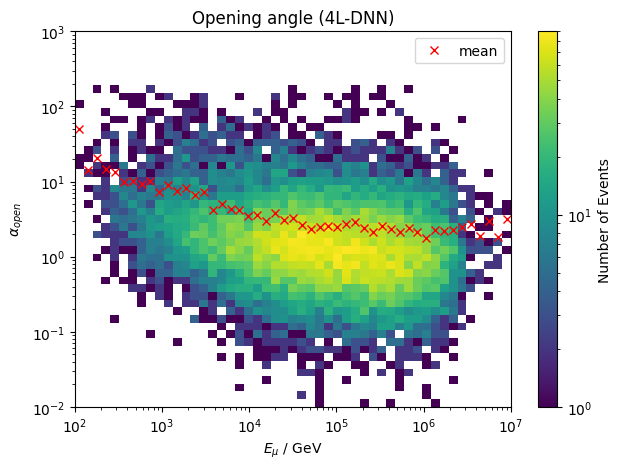

In [35]:
#hist uncut mean
plt.hist2d(MCdf.bundle_energy_at_entry, alpha_deg, bins=[xaxes,yaxes] ,cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_mean,'xr', label='mean')
plt.plot(label='Number of Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{open}$')
plt.colorbar(label='Number of Events')
plt.title('Opening angle (4L-DNN)')
plt.legend()
plt.tight_layout()
#plt.savefig('alpha_4L_mean')

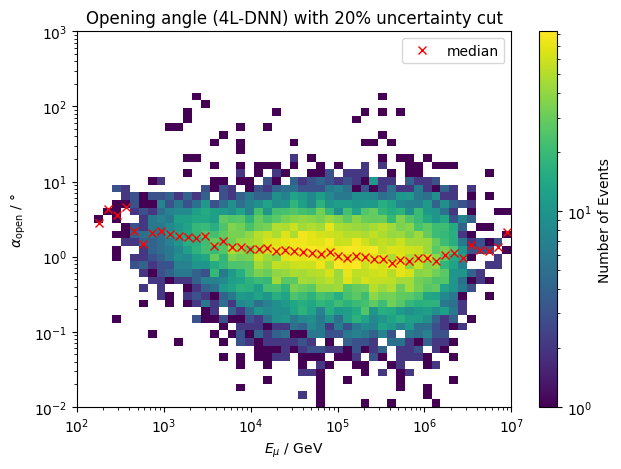

In [36]:
# hist cut median

plt.hist2d(plot_energy, alpha_deg_cut, bins=[xaxes,yaxes], cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_median_cut,'xr', label='median')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{\mathrm{open}}$ / °')
plt.colorbar(label='Number of Events')
plt.legend()
plt.title('Opening angle (4L-DNN) with 20% uncertainty cut')
plt.tight_layout()
plt.savefig('alpha_4L_median_cut_test_data')

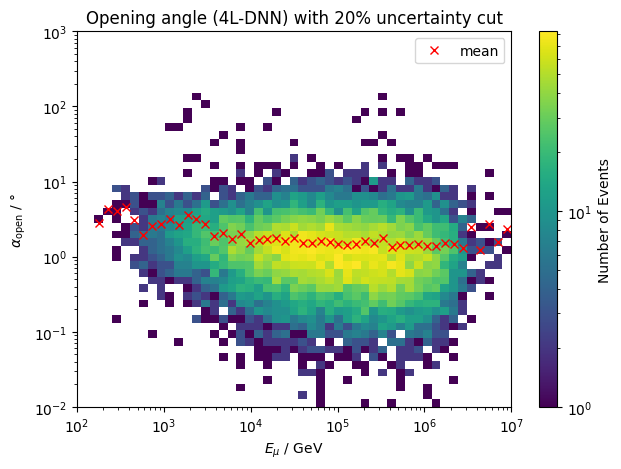

In [37]:
# hist cut mean

plt.hist2d(plot_energy, alpha_deg_cut, bins=[xaxes,yaxes], cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_mean_cut,'xr', label='mean') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{\mathrm{open}}$ / °')
plt.colorbar(label='Number of Events')
plt.title('Opening angle (4L-DNN) with 20% uncertainty cut')
plt.legend()
plt.tight_layout()
plt.savefig('alpha_4L_mean_cut_test_data')

In [38]:
#   -------------------------------------------------------------------------------------------------------------------
#   -------------------------------------------------------------------------------------------------------------------
#   network with 8 layers (first network)

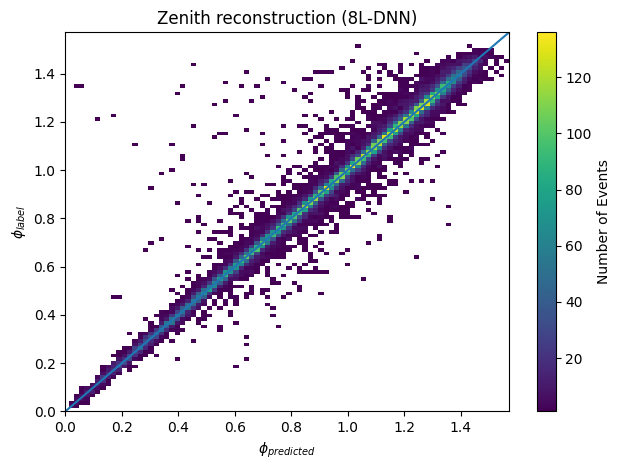

In [39]:
# Zenith reconstruction in radians for dnn with 8 layers

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(DNN_one_df.PrimaryZenith, MCdf.PrimaryZenith, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,np.pi/2)
plt.ylim(0,np.pi/2)
plt.xlabel(r'$\phi_{predicted}$')
plt.ylabel(r'$\phi_{label}$')
plt.title('Zenith reconstruction (8L-DNN)')
plt.tight_layout()
#plt.savefig('zenith_8L')

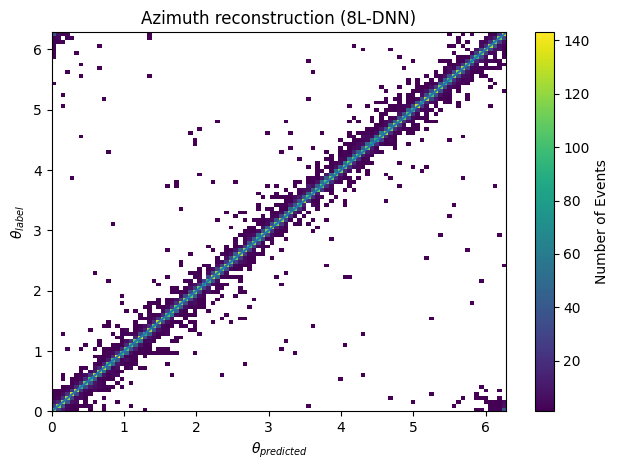

In [40]:
# Azimuth reconstruction in radians

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(DNN_one_df.PrimaryAzimuth, MCdf.PrimaryAzimuth, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
plt.xlabel(r'$\theta_{predicted}$')
plt.ylabel(r'$\theta_{label}$')
plt.title('Azimuth reconstruction (8L-DNN)')
plt.tight_layout()
#plt.savefig('azimuth_8L')

In [41]:
#   Uncertainty cut for Zenith uncertainty for first dnn with 8 layers
uncertainty_normed_zenith_one_cut=(DNN_one_df.PrimaryZenith_uncertainty-np.min(DNN_one_df.PrimaryZenith_uncertainty))/(np.max(DNN_one_df.PrimaryZenith_uncertainty)-np.min(DNN_one_df.PrimaryZenith_uncertainty))
uncertainty_normed_azimuth_one_cut=(DNN_one_df.PrimaryAzimuth_uncertainty-np.min(DNN_one_df.PrimaryAzimuth_uncertainty))/(np.max(DNN_one_df.PrimaryAzimuth_uncertainty)-np.min(DNN_one_df.PrimaryAzimuth_uncertainty))

#   Zenith

prediction_cut_zenith_one=DNN_one_df.PrimaryZenith[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.8)]
label_cut_zenith_one=MCdf.PrimaryZenith[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.8)]
#   Azimuth
prediction_cut_azimuth_one=DNN_one_df.PrimaryAzimuth[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.8)]
label_cut_azimuth_one=MCdf.PrimaryAzimuth[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.8)]

plot_energy_one=MCdf.bundle_energy_at_entry[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.8)]

In [42]:
# Uncertainty cut for MPEFit

MPE_zenith_cut=MPEdf.zenith[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.7)]
MPE_azimuth_cut=MPEdf.azimuth[uncertainty_normed_zenith_one_cut <= np.quantile(uncertainty_normed_zenith_one_cut, 0.7)]

In [43]:
# opening angle comparission for MPEFIt vs. MC leading muon with cut on MPE
# Zenith = phi ∈[0,pi]
# Azimuth = theta ∈[0,2pi]



cut_mpe_phi_predict=MPE_zenith_cut.values
cut_mpe_phi_label=label_cut_zenith_one.values
cut_mpe_theta_predict=MPE_azimuth_cut.values
cut_mpe_theta_label=label_cut_azimuth_one.values

# x,y,z coordinates of vektors for prediction
cut_mpe_theta_predict_x=np.sin(cut_mpe_theta_predict)*np.cos(cut_mpe_phi_predict)
cut_mpe_theta_predict_y=np.sin(cut_mpe_theta_predict)*np.sin(cut_mpe_phi_predict)
cut_mpe_theta_predict_z=np.cos(cut_mpe_theta_predict)

# x,y,z coordinates of vektors for label
cut_mpe_theta_label_x=np.sin(cut_mpe_theta_label)*np.cos(cut_mpe_phi_label)
cut_mpe_theta_label_y=np.sin(cut_mpe_theta_label)*np.sin(cut_mpe_phi_label)
cut_mpe_theta_label_z=np.cos(cut_mpe_theta_label)

# absolut value of vekotr
cut_absolute_mpe_predict=np.sqrt(cut_mpe_theta_predict_x**2+cut_mpe_theta_predict_y**2+cut_mpe_theta_predict_z**2)
cut_absolute_mpe_label=np.sqrt(cut_mpe_theta_label_x**2+cut_mpe_theta_label_y**2+cut_mpe_theta_label_z**2)

cut_MPE_alpha=np.arccos((cut_mpe_theta_predict_x*cut_mpe_theta_label_x+cut_mpe_theta_predict_y*cut_mpe_theta_label_y+cut_mpe_theta_predict_z*cut_mpe_theta_label_z)/(cut_absolute_mpe_predict*cut_absolute_mpe_label))

cut_MPE_alpha_deg=cut_MPE_alpha*360/(2*np.pi)
print(cut_MPE_alpha_deg)
print(np.isfinite(cut_MPE_alpha_deg))

ValueError: operands could not be broadcast together with shapes (13751,) (15715,) 

In [ ]:
# Calculate angle medians for energy bins for MPEFit cut

cut_MPE_angle_median=np.zeros(np.size(xaxes)-1)
#print(np.size(angle_median_leading))
cut_mpe_count=np.digitize(plot_energy_one, bins=xaxes)-1
#print(count)
for i in range(np.size(xaxes)-1):
    cut_pre_median_mpe=cut_MPE_alpha_deg[cut_mpe_count==i]
    cut_MPE_angle_median[i]=np.nanmedian(cut_pre_median_mpe)
#print(MPE_angle_median_leading)

In [ ]:
# Calculate angle means for energy bins for MPEFit 

cut_MPE_angle_mean=np.zeros(np.size(xaxes)-1)
#print(np.size(angle_median_leading))
cut_mpe_count=np.digitize(plot_energy_one, bins=xaxes)-1
#print(count)
for i in range(np.size(xaxes)-1):
    cut_pre_mean_mpe=cut_MPE_alpha_deg[cut_mpe_count==i]
    cut_MPE_angle_mean[i]=np.nanmean(cut_pre_mean_mpe)
#print(MPE_angle_median_leading)

/tmp/ipykernel_3897947/3378758836.py:9: RuntimeWarning: Mean of empty slice
  cut_MPE_angle_mean[i]=np.nanmean(cut_pre_mean_mpe)


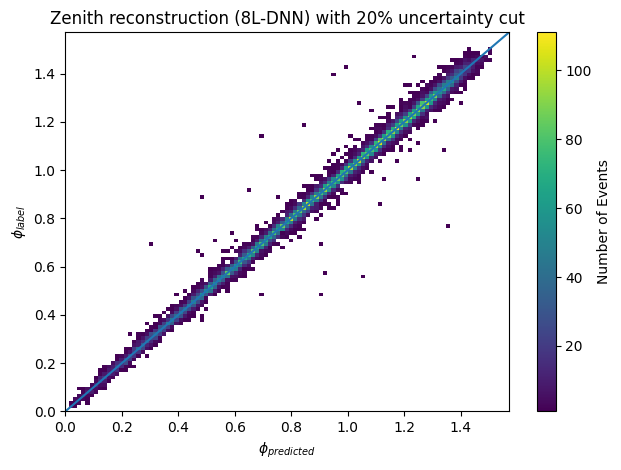

In [ ]:
# Zenith reconstruction in radians and uncertainty cut first dnn with 8 layers

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(prediction_cut_zenith_one, label_cut_zenith_one, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,np.pi/2)
plt.ylim(0,np.pi/2)
plt.xlabel(r'$\phi_{predicted}$')
plt.ylabel(r'$\phi_{label}$')
plt.title('Zenith reconstruction (8L-DNN) with 20% uncertainty cut')
plt.tight_layout()
#plt.savefig('zenith_8L_cut')

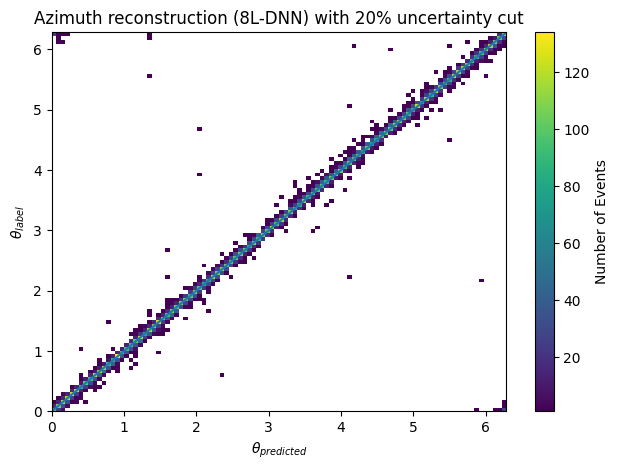

In [ ]:
# Azimuth reconstruction in radians and uncertainty cut for first dnn

ax=plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.hist2d(prediction_cut_azimuth_one, label_cut_azimuth_one, bins=100, cmin=1)
plt.colorbar(label='Number of Events')
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
plt.xlabel(r'$\theta_{predicted}$')
plt.ylabel(r'$\theta_{label}$')
plt.title('Azimuth reconstruction (8L-DNN) with 20% uncertainty cut')
plt.tight_layout()
#plt.savefig('azimuth_8L_cut')

In [ ]:
# opening angle for DNN vs. MC for smaller
phi_p_one=DNN_one_df.PrimaryZenith
phi_l_one=MCdf.PrimaryZenith
theta_p_one=DNN_one_df.PrimaryAzimuth 
theta_l_one=MCdf.PrimaryAzimuth 

# x,y,z coordinates of vektors for prediction
theta_px_one=np.sin(theta_p_one)*np.cos(phi_p_one)
theta_py_one=np.sin(theta_p_one)*np.sin(phi_p_one)
theta_pz_one=np.cos(theta_p_one)

# x,y,z coordinates of vektors for label
theta_lx_one=np.sin(theta_l_one)*np.cos(phi_l_one)
theta_ly_one=np.sin(theta_l_one)*np.sin(phi_l_one)
theta_lz_one=np.cos(theta_l_one)

# absolut value of vekotr
absolute_p_one=np.sqrt(theta_px_one**2+theta_py_one**2+theta_pz_one**2)
absolute_l_one=np.sqrt(theta_lx_one**2+theta_ly_one**2+theta_lz_one**2)

alpha_one=np.arccos((theta_px_one*theta_lx_one+theta_py_one*theta_ly_one+theta_pz_one*theta_lz_one)/(absolute_p_one*absolute_l_one))

alpha_deg_one=alpha_one*360/(2*np.pi)

In [ ]:
# opening angle for DNN vs. MC with cut for smaller dnn
phi_p_one_cut=prediction_cut_zenith_one
phi_l_one_cut=label_cut_zenith_one
theta_p_one_cut=prediction_cut_azimuth_one 
theta_l_one_cut=label_cut_azimuth_one

# x,y,z coordinates of vektors for prediction
theta_px_one_cut=np.sin(theta_p_one_cut)*np.cos(phi_p_one_cut)
theta_py_one_cut=np.sin(theta_p_one_cut)*np.sin(phi_p_one_cut)
theta_pz_one_cut=np.cos(theta_p_one_cut)

# x,y,z coordinates of vektors for label
theta_lx_one_cut=np.sin(theta_l_one_cut)*np.cos(phi_l_one_cut)
theta_ly_one_cut=np.sin(theta_l_one_cut)*np.sin(phi_l_one_cut)
theta_lz_one_cut=np.cos(theta_l_one_cut)

# absolut value of vekotr
absolute_p_one_cut=np.sqrt(theta_px_one_cut**2+theta_py_one_cut**2+theta_pz_one_cut**2)
absolute_l_one_cut=np.sqrt(theta_lx_one_cut**2+theta_ly_one_cut**2+theta_lz_one_cut**2)

alpha_one_cut=np.arccos((theta_px_one_cut*theta_lx_one_cut+theta_py_one_cut*theta_ly_one_cut+theta_pz_one_cut*theta_lz_one_cut)/(absolute_p_one_cut*absolute_l_one_cut))

alpha_deg_one_cut=alpha_one_cut*360/(2*np.pi)

In [ ]:
print(np.size(plot_energy_one))
print(np.size(alpha_deg_one))

15715
19644


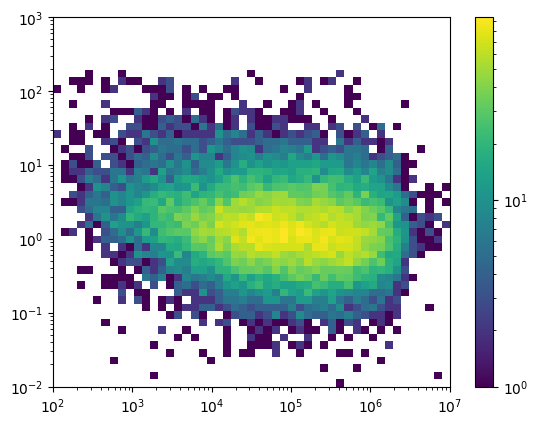

In [ ]:
plt.hist2d(MCdf.bundle_energy_at_entry, alpha_deg_one, bins=[xaxes,yaxes] ,cmin=1, norm='log')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

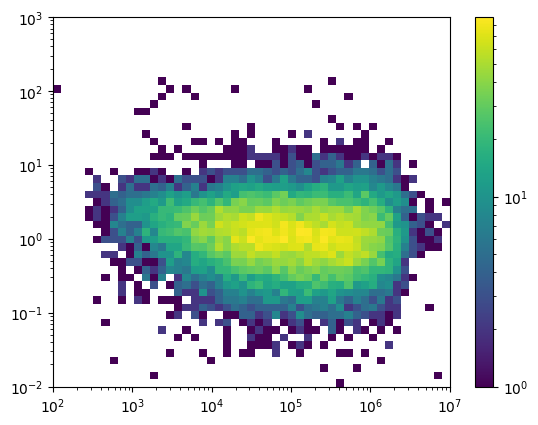

In [ ]:
plt.hist2d(plot_energy_one, alpha_deg_one_cut, bins=[xaxes,yaxes] ,cmin=1, norm='log')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [ ]:
# Calculate angle medians for energy bins for uncut 

angle_median_one=np.zeros(np.size(xaxes)-1)
x_one=np.digitize(MCdf.bundle_energy_at_entry, bins=xaxes)-1
#print(x)
for n in range(np.size(xaxes)-1):
    z_one=alpha_deg_one[x_one==n]
    angle_median_one[n]=np.median(z_one)
#print(angle_median)
#print(max(x))

In [ ]:
# Calculate angle means for energy bins for uncut 

angle_mean_one=np.zeros(np.size(xaxes)-1)
x_one=np.digitize(MCdf.bundle_energy_at_entry, bins=xaxes)-1
#print(x)
for n in range(np.size(xaxes)-1):
    z_one=alpha_deg_one[x_one==n]
    angle_mean_one[n]=np.mean(z_one)
#print(angle_mean)
#print(max(x))

In [ ]:
# Calculate angle medians for energy bins for cut 

angle_median_one_cut=np.zeros(np.size(xaxes)-1)
y_one_cut=np.digitize(plot_energy_one, bins=xaxes)-1
#print(y)
for i in range(np.size(xaxes)-1):
    k_one_cut=alpha_deg_one_cut[y_one_cut==i]
    angle_median_one_cut[i]=np.nanmedian(k_one_cut)
#print(angle_median_cut)
#print(max(y))

In [ ]:
angle_median_cut

array([       nan,        nan, 2.83997501, 4.27257334, 3.58923159,
       4.54313677, 2.1804396 , 1.46019923, 2.04144935, 2.17771084,
       1.99135323, 1.87987736, 1.82669133, 1.77141147, 1.87236625,
       1.36973754, 1.60451711, 1.36388242, 1.34100595, 1.25170877,
       1.24591706, 1.29902389, 1.1919269 , 1.22155799, 1.19976714,
       1.14535532, 1.1222549 , 1.09216911, 1.14922499, 1.02048171,
       0.95409489, 1.01204862, 0.98561112, 0.94016863, 0.92125534,
       0.8191829 , 0.90863009, 0.87838522, 0.95849608, 0.96145079,
       0.86451789, 1.0382801 , 1.10457482, 0.94902113, 1.44365079,
       1.2184639 , 1.19148397, 1.33845325, 2.12787783])

In [ ]:
angle_median_one_cut

array([104.0595623 ,          nan,          nan,          nan,
         3.56255778,   2.87357277,   1.53507603,   1.73446908,
         1.77907434,   2.18011979,   1.96928857,   1.67529447,
         1.88632739,   1.58928809,   1.49943144,   1.3697542 ,
         1.52914583,   1.33780969,   1.27844537,   1.21243046,
         1.28399516,   1.27140148,   1.12333925,   1.16552709,
         1.09645495,   1.14638617,   1.10903334,   1.06561735,
         1.12325431,   1.03966385,   1.02874935,   1.0043469 ,
         1.00918768,   1.02282509,   0.99422388,   0.98969379,
         0.94350669,   1.06530284,   1.07700147,   1.11515366,
         1.05084389,   1.14478724,   1.04401246,   1.33663232,
         1.61144486,   1.6017064 ,   1.25968223,   0.94888751,
         1.74884908])

In [ ]:
# Calculate angle means for energy bins for cut 

angle_mean_one_cut=np.zeros(np.size(xaxes)-1)
y_once_cut=np.digitize(plot_energy_one, bins=xaxes)-1
#print(y)
for i in range(np.size(xaxes)-1):
    k_one_cut=alpha_deg_one_cut[y_one_cut==i]
    angle_mean_one_cut[i]=np.nanmean(k_one_cut)
#print(angle_mean_cut)
#print(max(y))

/tmp/ipykernel_3962432/2389560641.py:8: RuntimeWarning: Mean of empty slice
  angle_mean_one_cut[i]=np.nanmean(k_one_cut)


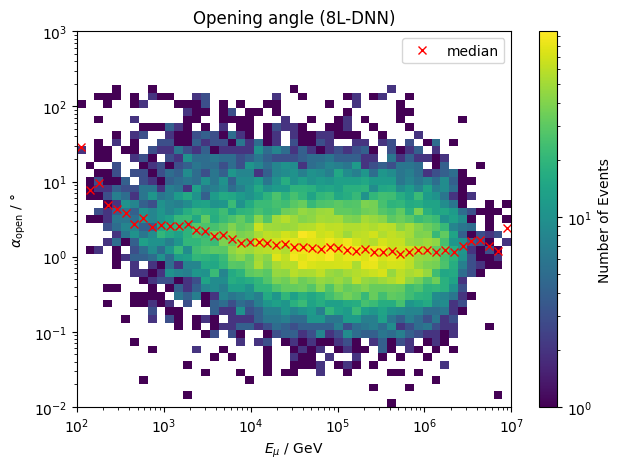

In [ ]:
# hist uncut median 8L dnn
plt.hist2d(MCdf.bundle_energy_at_entry, alpha_deg_one, bins=[xaxes,yaxes] ,cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_median_one,'xr', label='median')
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{\mathrm{open}}$ / °')
plt.colorbar(label='Number of Events')
plt.title('Opening angle (8L-DNN)')
plt.legend()
plt.tight_layout()
#plt.savefig('alpha_8L_median')

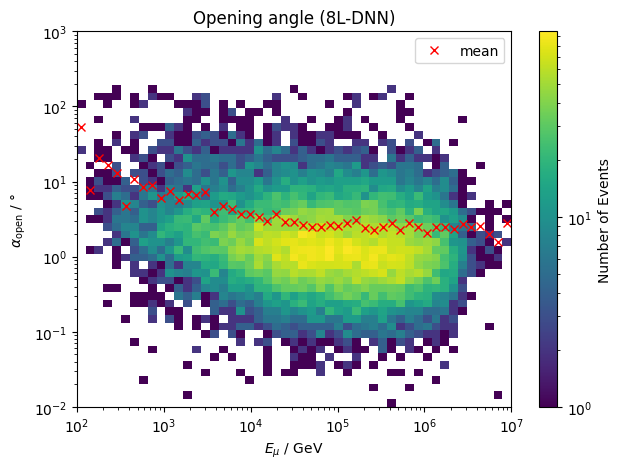

In [ ]:
#hist uncut mean 8L dnn
plt.hist2d(MCdf.bundle_energy_at_entry, alpha_deg_one, bins=[xaxes,yaxes] ,cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_mean_one,'xr', label='mean')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{\mathrm{open}}$ / °')
plt.colorbar(label='Number of Events')
plt.title('Opening angle (8L-DNN)')
plt.legend()
plt.tight_layout()
#plt.savefig('alpha_8L_mean')

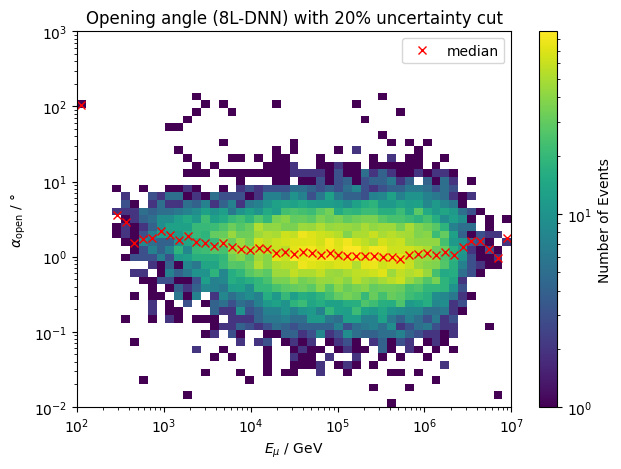

In [ ]:
# hist cut median 8L dnn

plt.hist2d(plot_energy_one, alpha_deg_one_cut, bins=[xaxes,yaxes], cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_median_one_cut,'xr', label='median')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{\mathrm{open}}$ / °')
plt.colorbar(label='Number of Events')
plt.title('Opening angle (8L-DNN) with 20% uncertainty cut')
plt.legend()
plt.tight_layout()
plt.savefig('alpha_8L_median_cut_test_data')

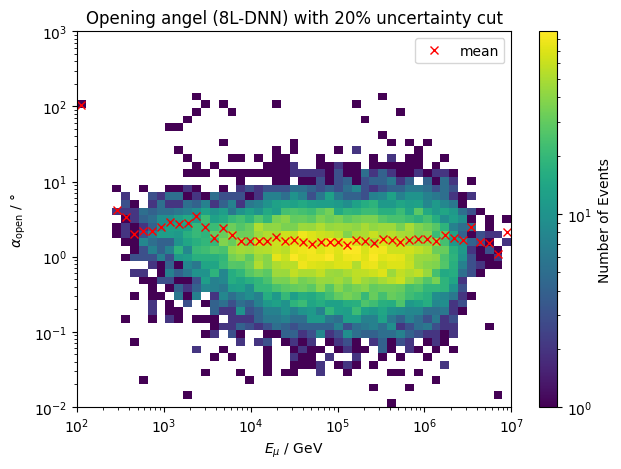

In [ ]:
# hist cut mean 8L dnn

plt.hist2d(plot_energy_one, alpha_deg_one_cut, bins=[xaxes,yaxes], cmin=1, norm='log')
plt.plot(middle_value_non_log,angle_mean_one_cut,'xr', label='mean')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{\mathrm{open}}$ / °')
plt.colorbar(label='Number of Events')
plt.title('Opening angel (8L-DNN) with 20% uncertainty cut')
plt.legend()
plt.tight_layout()
plt.savefig('alpha_8L_mean_cut_test_data')

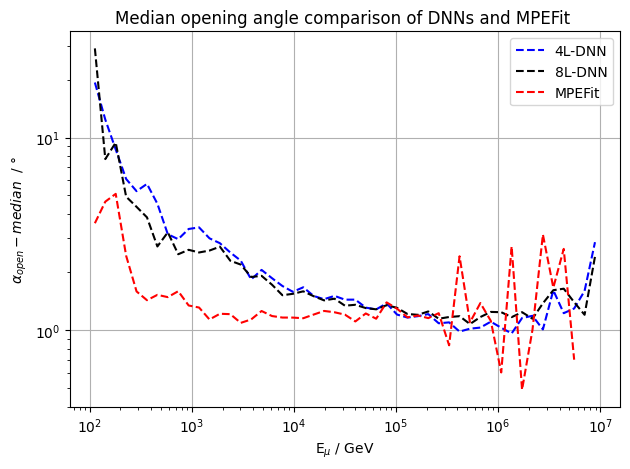

In [ ]:
# Median compaission of MPEFit vs DNN for leading muon

plt.plot(middle_value_non_log,angle_median,'--b', label='4L-DNN')
plt.plot(middle_value_non_log,angle_median_one,'--k', label='8L-DNN')
plt.plot(middle_value_non_log,MPE_angle_median, '--r', label='MPEFit')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'E$_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{open}-  median$  / °')
plt.grid()
plt.title('Median opening angle comparison of DNNs and MPEFit ')
plt.tight_layout()
#plt.savefig('mpe_vs_dnns_median')

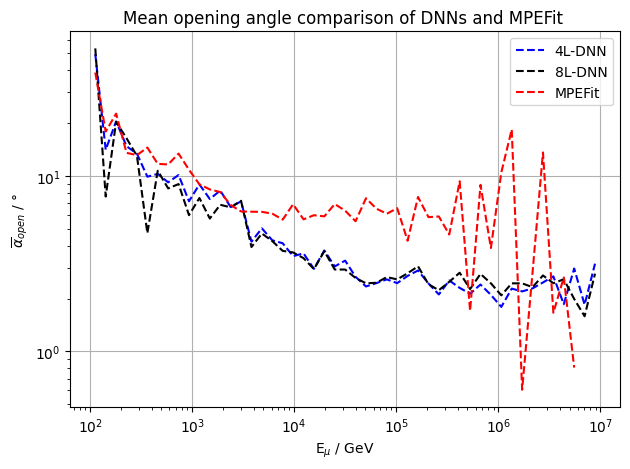

In [ ]:
# Mean compaission of MPEFit vs DNN for leading muon

plt.plot(middle_value_non_log,angle_mean,'--b', label='4L-DNN')
plt.plot(middle_value_non_log,angle_mean_one,'--k', label='8L-DNN')
plt.plot(middle_value_non_log,MPE_angle_mean, '--r', label='MPEFit')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'E$_{\mu}$ / GeV')
plt.ylabel(r'$\overline{\alpha}_{open}$ / °')
plt.grid()
plt.title('Mean opening angle comparison of DNNs and MPEFit ')
plt.tight_layout()
#plt.savefig('mpe_vs_dnn_mean')

NameError: name 'cut_MPE_angle_median' is not defined

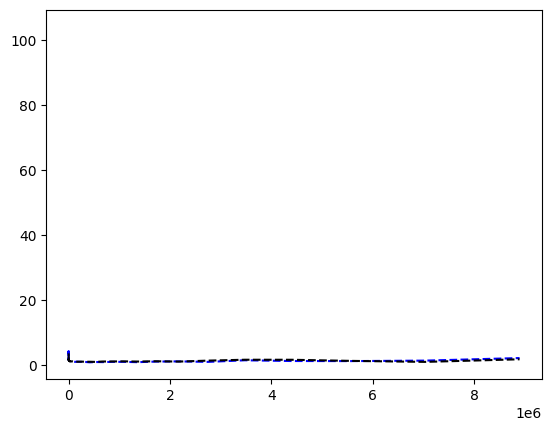

In [ ]:
# Median compaission of MPEFit vs DNN for leading muon with cut

plt.plot(middle_value_non_log,angle_median_cut,'--b', label='4L-DNN')
plt.plot(middle_value_non_log,angle_median_one_cut,'--k', label='8L-DNN')
plt.plot(middle_value_non_log,cut_MPE_angle_median, '--r', label='MPEFit')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'E$_{\mu}$ / GeV')
plt.ylabel(r'$\alpha_{open}-  median$  / °')
plt.ylim(3*10**(-1),10**1)
plt.grid()
plt.title('Median opening angle comparison of DNNs and MPEFit with cut')
#plt.savefig('mpe_vs_dnns_median_cut')

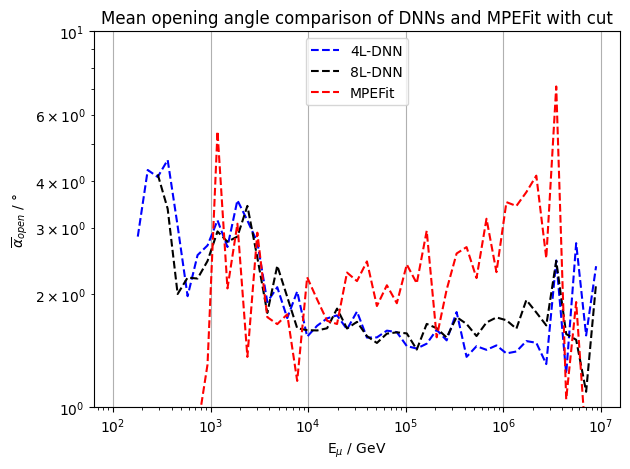

In [ ]:
# Mean compaission of MPEFit vs DNN for leading muon with cut

plt.plot(middle_value_non_log,angle_mean_cut,'--b', label='4L-DNN')
plt.plot(middle_value_non_log,angle_mean_one_cut,'--k', label='8L-DNN')
plt.plot(middle_value_non_log,cut_MPE_angle_mean, '--r', label='MPEFit')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**0,10**1)
plt.legend()
plt.xlabel(r'E$_{\mu}$ / GeV')
plt.ylabel(r'$\overline{\alpha}_{open}$ / °')
plt.grid()
plt.title('Mean opening angle comparison of DNNs and MPEFit with cut')
plt.tight_layout()
#plt.savefig('mpe_vs_dnn_mean_cut')

In [ ]:
print(np.mean(DNNdf.runtime_prediction))
print(np.median(DNNdf.runtime_prediction))
print(np.mean(DNN_one_df.runtime_prediction))
print(np.median(DNN_one_df.runtime_prediction))


0.018776896712308585
0.017303063650615513
0.020775869600817135
0.01811317523772066


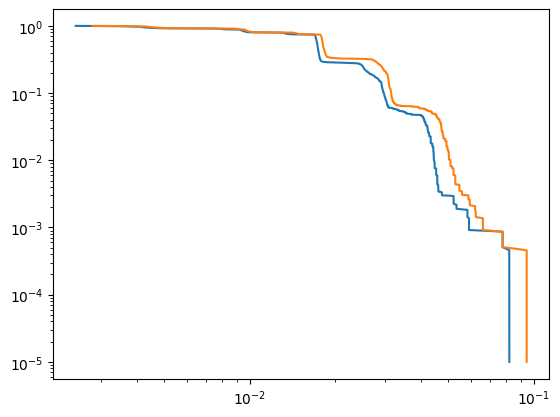

In [ ]:
#   runtime plots 
p2=np.logspace(-5,0,1000)
plt.plot(np.quantile(DNNdf.runtime_prediction,1-p2),p2,label='4L')
plt.plot(np.quantile(DNN_one_df.runtime_prediction,1-p2),p2,label='8L')
plt.xscale('log')
plt.yscale('log')

In [ ]:
np.size(DNNdf.PrimaryZenith[MCdf.entry_energy>10**6])

51

In [ ]:
#   Uncertainty cut for Zenith uncertainty pool
uncertainty_normed_zenith_pool=(DNNpdf.PrimaryZenith_uncertainty-np.min(DNNpdf.PrimaryZenith_uncertainty))/(np.max(DNNpdf.PrimaryZenith_uncertainty)-np.min(DNNpdf.PrimaryZenith_uncertainty))
uncertainty_normed_azimuth_pool=(DNNpdf.PrimaryAzimuth_uncertainty-np.min(DNNpdf.PrimaryAzimuth_uncertainty))/(np.max(DNNpdf.PrimaryAzimuth_uncertainty)-np.min(DNNpdf.PrimaryAzimuth_uncertainty))

#   Zenith

prediction_cut_zenith_pool=DNNpdf.PrimaryZenith[uncertainty_normed_zenith_pool <= np.quantile(uncertainty_normed_zenith_pool, 0.8)]
label_cut_zenith_pool=MCdf.PrimaryZenith[uncertainty_normed_zenith_pool <= np.quantile(uncertainty_normed_zenith_pool, 0.8)]
#   Azimuth
prediction_cut_azimuth_pool=DNNpdf.PrimaryAzimuth[uncertainty_normed_zenith_pool <= np.quantile(uncertainty_normed_zenith_pool, 0.8)]
label_cut_azimuth_pool=MCdf.PrimaryAzimuth[uncertainty_normed_zenith_pool <= np.quantile(uncertainty_normed_zenith_pool, 0.8)]

#plot_energy=MCdf.bundle_energy_at_entry[uncertainty_normed_zenith <= np.quantile(uncertainty_normed_zenith, 0.8)]

In [ ]:
# opening angle for DNN vs. MC with uncertainty cut pool 

phi_p_cut_pool=DNNpdf.PrimaryZenith.values
phi_l_cut_pool=MCdf.PrimaryZenith.values
theta_p_cut_pool=DNNpdf.PrimaryAzimuth.values
theta_l_cut_pool=MCdf.PrimaryAzimuth.values

# x,y,z coordinates of vektors for prediction
theta_px_cut_pool=np.sin(theta_p_cut_pool)*np.cos(phi_p_cut_pool)
theta_py_cut_pool=np.sin(theta_p_cut_pool)*np.sin(phi_p_cut_pool)
theta_pz_cut_pool=np.cos(theta_p_cut_pool)

# x,y,z coordinates of vektors for label
theta_lx_cut_pool=np.sin(theta_l_cut_pool)*np.cos(phi_l_cut_pool)
theta_ly_cut_pool=np.sin(theta_l_cut_pool)*np.sin(phi_l_cut_pool)
theta_lz_cut_pool=np.cos(theta_l_cut_pool)

# absolut value of vekotr
absolute_p_cut_pool=np.sqrt(theta_px_cut_pool**2+theta_py_cut_pool**2+theta_pz_cut_pool**2)
absolute_l_cut_pool=np.sqrt(theta_lx_cut_pool**2+theta_ly_cut_pool**2+theta_lz_cut_pool**2)
# opening angle

alpha_cut_pool=np.arccos((theta_px_cut_pool*theta_lx_cut_pool+theta_py_cut_pool*theta_ly_cut_pool+theta_pz_cut_pool*theta_lz_cut_pool)/(absolute_p_cut_pool*absolute_l_cut_pool))

alpha_deg_cut_pool=alpha_cut_pool*360/(2*np.pi)

In [ ]:
# Calculate angle medians for energy bins for cut pool

angle_median_cut_pool=np.zeros(np.size(xaxes)-1)
y_cut_pool=np.digitize(MCdf.entry_energy, bins=xaxes)-1
#print(y)
for i in range(np.size(xaxes)-1):
    k_cut_pool=alpha_deg_cut_pool[y_cut_pool==i]
    angle_median_cut_pool[i]=np.nanmedian(k_cut_pool)
print(angle_median_cut_pool)
#print(max(y))

[60.68360762 10.18349134 15.6874446   6.28842825  5.22346538  4.24284028
  4.92595362  3.16957023  3.52076055  3.11620022  2.65277267  2.05216792
  2.09211249  1.89217007  1.88819598  1.65951393  1.68125432  1.55261746
  1.54334379  1.53217133  1.45044659  1.42487508  1.34369004  1.3791183
  1.28485078  1.26248643  1.20890707  1.26029813  1.34070272  1.35379956
  1.07553389  1.4079587   1.67676478  1.39340861  1.39873259  2.09265664
  1.49541959  1.40709759  2.26682673  1.54007401  2.25334802  1.05677027
  1.38553913  2.0588971   5.04340525  2.00626575  2.88630403         nan
  1.38068218]


/scratch/bbrandt/muonspace/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
angle_median_cut_pool

array([60.68360762, 10.18349134, 15.6874446 ,  6.28842825,  5.22346538,
        4.24284028,  4.92595362,  3.16957023,  3.52076055,  3.11620022,
        2.65277267,  2.05216792,  2.09211249,  1.89217007,  1.88819598,
        1.65951393,  1.68125432,  1.55261746,  1.54334379,  1.53217133,
        1.45044659,  1.42487508,  1.34369004,  1.3791183 ,  1.28485078,
        1.26248643,  1.20890707,  1.26029813,  1.34070272,  1.35379956,
        1.07553389,  1.4079587 ,  1.67676478,  1.39340861,  1.39873259,
        2.09265664,  1.49541959,  1.40709759,  2.26682673,  1.54007401,
        2.25334802,  1.05677027,  1.38553913,  2.0588971 ,  5.04340525,
        2.00626575,  2.88630403,         nan,  1.38068218])

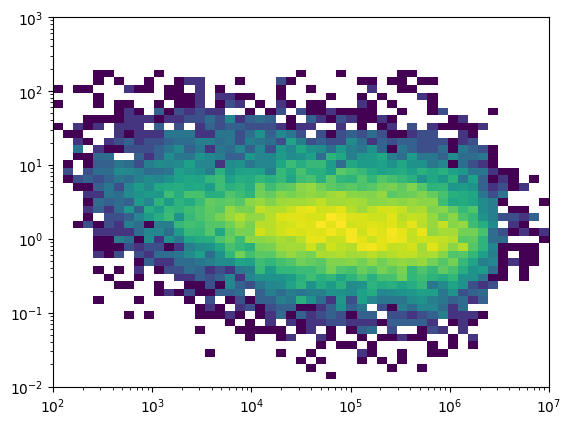

In [ ]:
plt.hist2d(MCdf.bundle_energy_at_entry,alpha_deg_cut_pool, cmin=1, bins=[xaxes,yaxes], norm='log')
plt.xscale('log')
plt.yscale('log')
plt.savefig('ohboy')